In [1]:
import torch
from torch.utils.data import DataLoader 
import torchvision.transforms as T
import yaml
import os
import matplotlib.pyplot as plt
from utils.utils import CosineLoss
from models.features_extractors import EfficientNet_feature_B5
import os
from utils.utils import GaussianSmoothing
from dataset.video_dataset import ImageSequenceDataset
import onnxruntime as ort
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open('configs/config_inference.yaml', 'r') as file:
    config = yaml.safe_load(file)

    
data_visu_path = 'data_visu/AD'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_SN = torch.load(config['general_config']['weight_path_SimpleNet']).to(device)
model_SN.eval()

model_GeneralAD = torch.load(config['general_config']['weight_path_generalAD']).to(device)
model_GeneralAD.eval()


model_PatchCore = torch.load(config['general_config']['weight_path_PatchCore'])

# Load the exported ONNX model
onnx_model_path = config['general_config']['weight_path_VMTAD_onnx']
VMTAD_session = ort.InferenceSession(onnx_model_path, providers=['CUDAExecutionProvider'])

feature_extraction  = EfficientNet_feature_B5(config)
feature_extraction.eval()   


preprocessing_efficientnet = T.Compose([
    T.Resize((config['general_config']['image_size'], 
              config['general_config']['image_size']), 
             interpolation=T.InterpolationMode.BICUBIC),
    T.ToTensor(),
    T.Normalize(mean=[0.4850, 0.4560, 0.4060],
                std=[0.2290, 0.2240, 0.2250])
])

inv = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ])   ])

# Create validation dataset
dataset_val = ImageSequenceDataset(
    os.path.join(data_visu_path),
    1,
    preprocessing_efficientnet,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False
)


#setup tqdm
loss_eval = []
loss_visu = CosineLoss()
gs_filter = GaussianSmoothing(kernel_size=3)

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


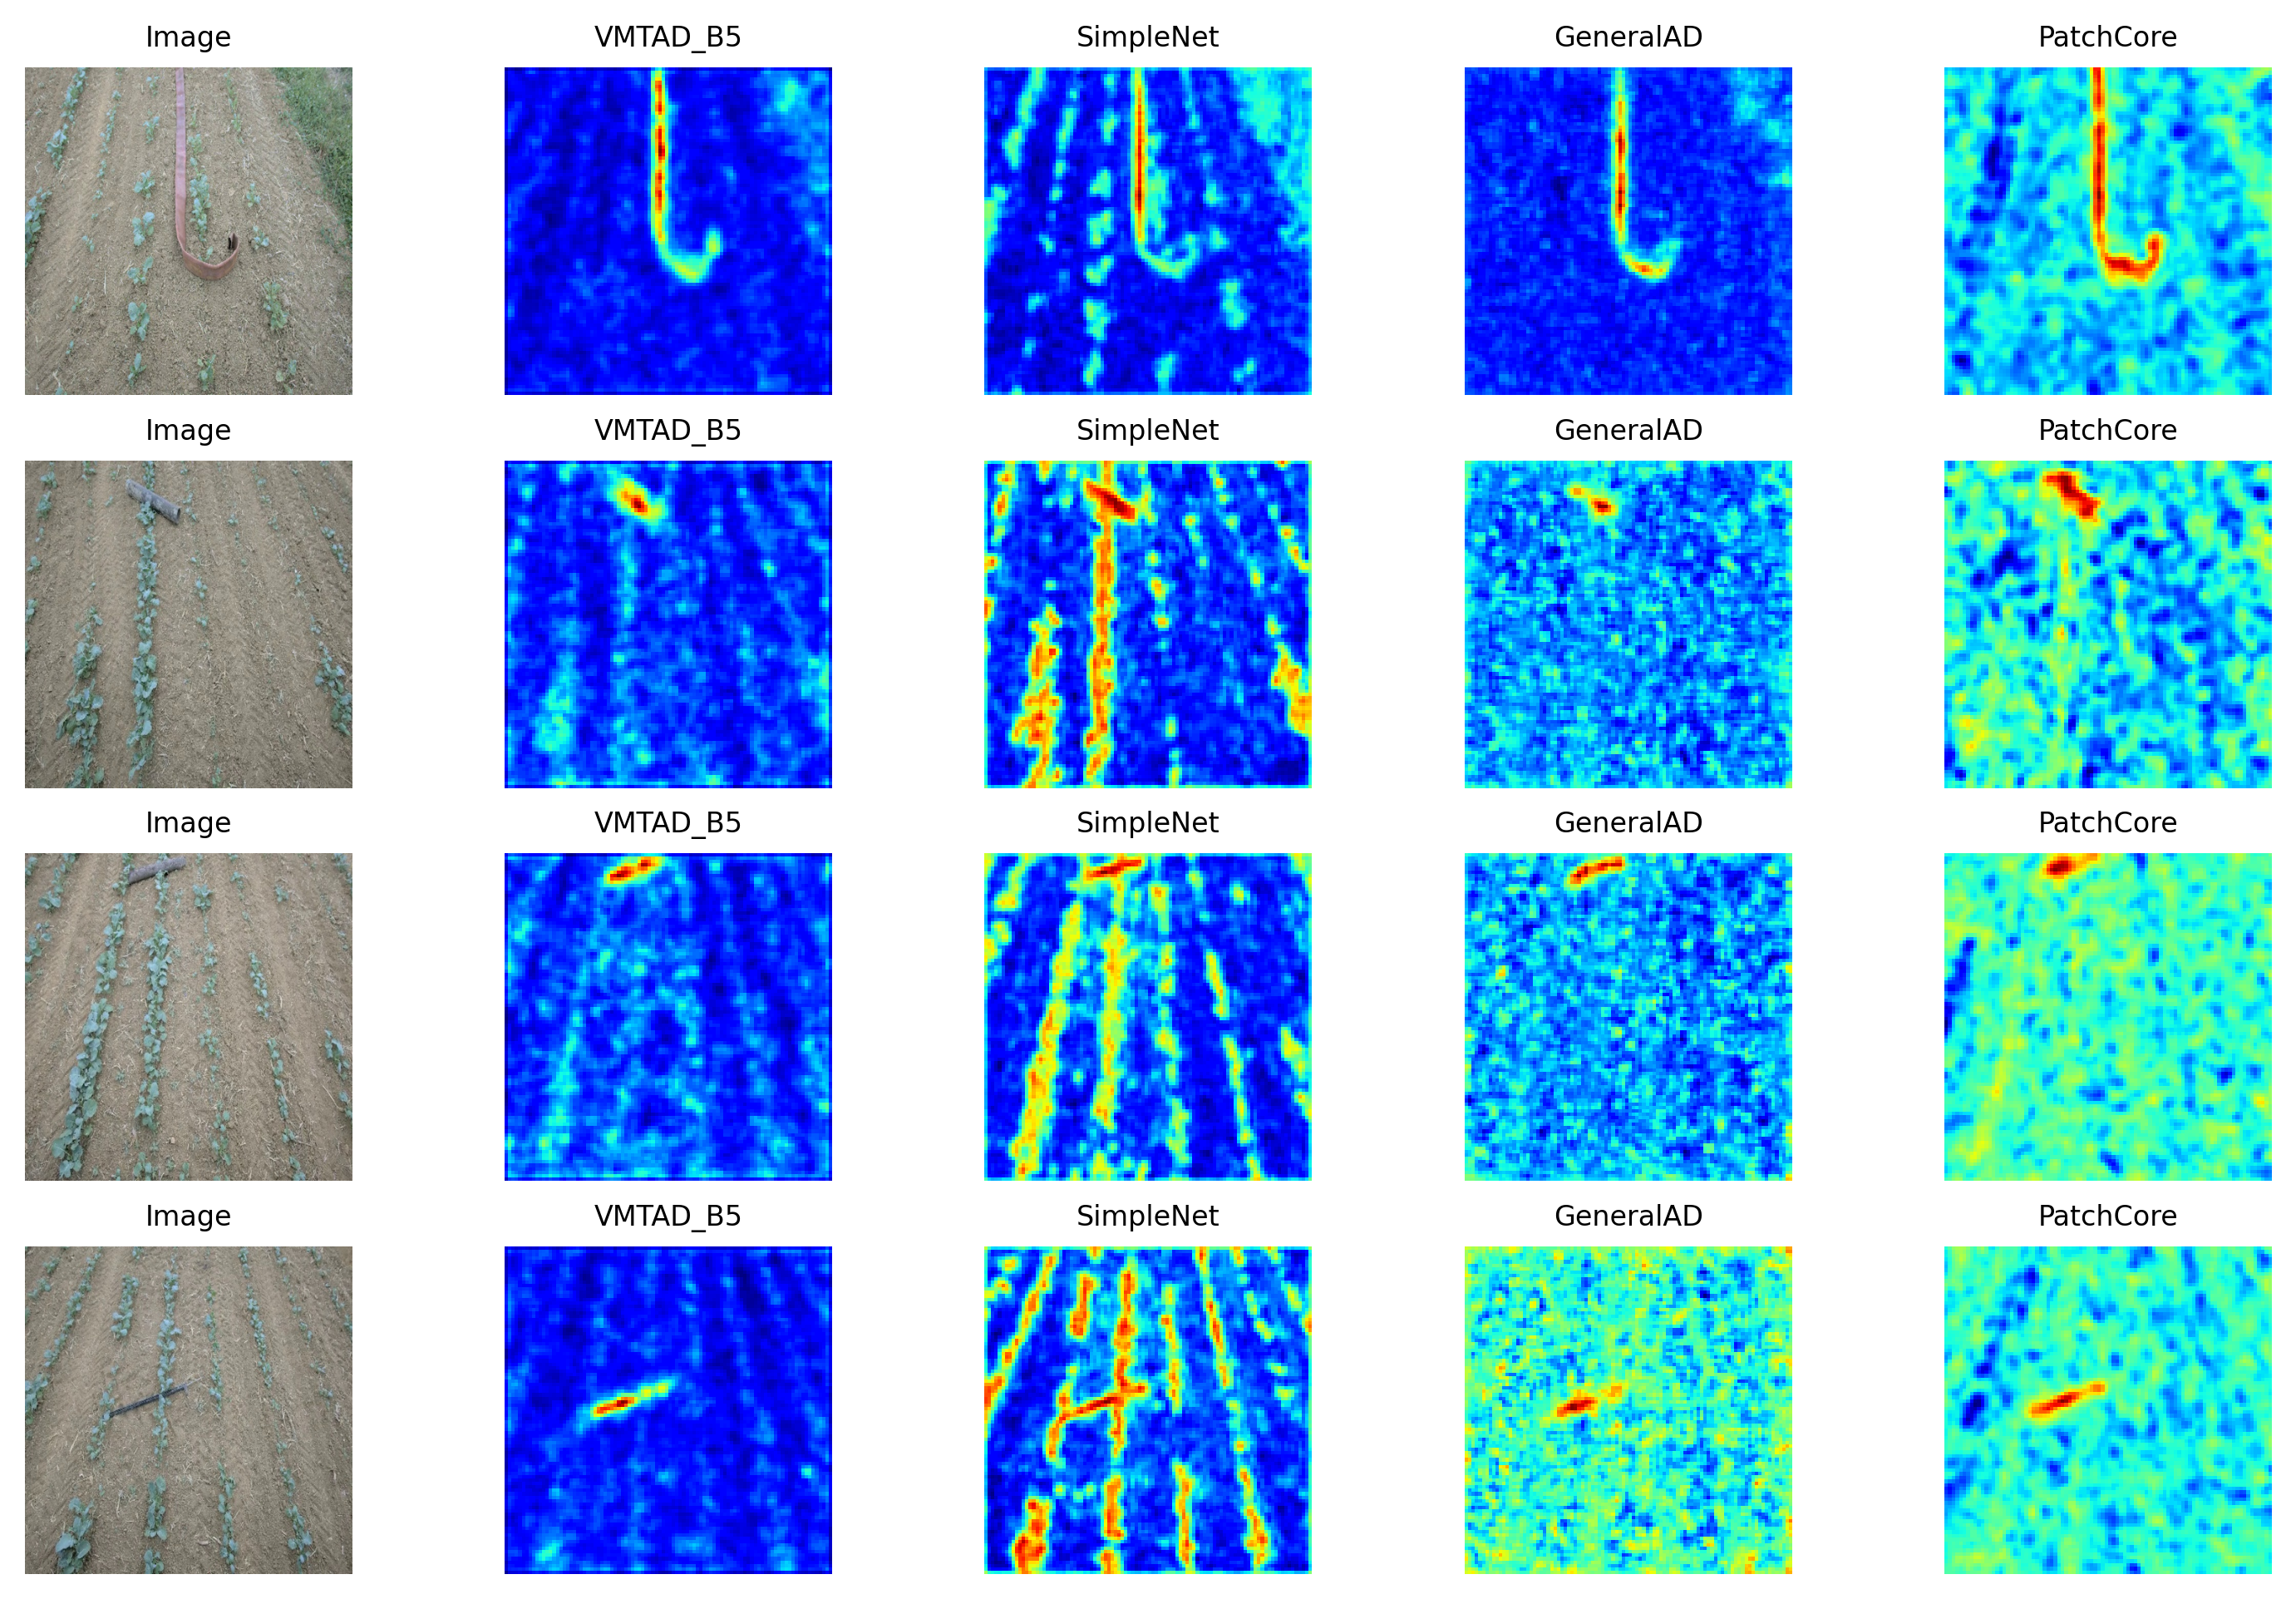

In [6]:
last_folder = None
i = 0
figs, axs = plt.subplots(4,5)

for y, (folder, images) in enumerate(dataloader_val) :
    if y == 0 : last_folder = folder
    if y!=0 and folder!=last_folder :
            last_folder = folder
            
            axs[i,0].imshow(inv(image_gpu)[0].transpose(2,0).transpose(1,0).cpu())
            axs[i,0].axis('off')
            axs[i,0].set_title('Image', fontsize=8)
            axs[i,1].imshow(visu_VMTAD[0], cmap='jet')
            axs[i,1].axis('off')
            axs[i,1].set_title('VMTAD_B5', fontsize=8)
            axs[i,2].imshow(visu_SN[0], cmap='jet')
            axs[i,2].axis('off')
            axs[i,2].set_title('SimpleNet', fontsize=8)
            axs[i,3].imshow(visu_GeneralAD[0], cmap='jet')
            axs[i,3].axis('off')
            axs[i,3].set_title('GeneralAD', fontsize=8)
            axs[i,4].imshow(visu_patchcore[0][2:-2,2:-2], cmap='jet')
            axs[i,4].axis('off')
            axs[i,4].set_title('PatchCore', fontsize=8)
            
            i += 1
    image_gpu = images[0].to(device)

    with torch.no_grad():
        onnx_input_name = VMTAD_session.get_inputs()[0].name  
        input_features=feature_extraction(image_gpu).detach().cpu().numpy().astype(np.float32)
        outputs = VMTAD_session.run(['output', 'src'], {onnx_input_name: input_features})
        output = outputs[0]
        src = outputs[1]
        visu_loss = loss_visu(torch.from_numpy(output).to('cuda'),torch.from_numpy(src).to('cuda'))
        visu_VMTAD = gs_filter(visu_loss).detach().cpu().numpy()


    with torch.no_grad():
        outputs = model_SN(feature_extraction(image_gpu), mode='inference')
        visu_SN = gs_filter(outputs)[0].detach().cpu().numpy()
        
    with torch.no_grad():
        outputs = model_GeneralAD(feature_extraction(image_gpu), generate_anomaly=False)
        visu_GeneralAD = gs_filter(outputs).detach().cpu().numpy()
        
    with torch.no_grad():
        outputs = model_PatchCore.compute_anomaly_map(feature_extraction(image_gpu))
        visu_patchcore = gs_filter(outputs[1].unsqueeze(0)).detach().cpu().numpy()

# i += 1
axs[i,0].imshow(inv(image_gpu)[0].transpose(2,0).transpose(1,0).cpu())
axs[i,0].axis('off')
axs[i,0].set_title('Image', fontsize=8)
axs[i,1].imshow(visu_VMTAD[0], cmap='jet')
axs[i,1].axis('off')
axs[i,1].set_title('VMTAD_B5', fontsize=8)
axs[i,2].imshow(visu_SN[0], cmap='jet')
axs[i,2].axis('off')
axs[i,2].set_title('SimpleNet', fontsize=8)
axs[i,3].imshow(visu_GeneralAD[0], cmap='jet')
axs[i,3].axis('off')
axs[i,3].set_title('GeneralAD', fontsize=8)
axs[i,4].imshow(visu_patchcore[0][2:-2,2:-2], cmap='jet')
axs[i,4].axis('off')
axs[i,4].set_title('PatchCore', fontsize=8)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 300 # 200 e.g. is really fine, but slower

plt.show()

